Project description

There is an agency helping the customers purchase XoX (a made-up product) from various makers. Price is one of the most important things that the agency cares about. Need to estimate the price of a XoX before recommending it to the customers. However, the estimations vary significantly with the employees' experience.

I am building a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers.

# 1.Exploratory data analysis (EDA)

Feature Columns, Missing values, Target Label, Shape, Distribution, Skewness.

In [78]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.compose import make_column_transformer,ColumnTransformer
import category_encoders
import phik
from phik import resources, report
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

df = pd.read_csv('sales.csv')
df.dropna(subset=['price'], inplace=True)

In [79]:
#Have a glance at the data
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [80]:
#Get names of columns
df.columns

Index(['cost', 'price', 'weight', 'purchase_date', 'product_type',
       'product_level', 'maker', 'ingredient', 'height', 'width', 'depth'],
      dtype='object')

In [81]:
#Get the number of rows and number of columns.
df.shape 

(3186, 11)

In [82]:
#Overview of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186 entries, 0 to 3196
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2211 non-null   object
 1   price          3186 non-null   object
 2   weight         3183 non-null   object
 3   purchase_date  3186 non-null   object
 4   product_type   3186 non-null   object
 5   product_level  3186 non-null   object
 6   maker          2365 non-null   object
 7   ingredient     2932 non-null   object
 8   height         3186 non-null   object
 9   width          3183 non-null   object
 10  depth          3183 non-null   object
dtypes: object(11)
memory usage: 298.7+ KB


In [83]:
'''
count: It indicates the number of valid (non-missing) values present in the column.
top: It shows the value that occurs most frequently in the column.
unique: It indicates the count of different values present in the column.
freq: It shows how many times the most frequent value occurs in the column.
'''
df.describe()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
count,2211,3186,3183,3186,3186,3186,2365,2932,3186,3183,3183
unique,185,3157,119,1277,64,5,879,2824,161,41,13
top,$66k,"$20,061",2 Ton 950 Kg,Oct 05 2001,D,advanced,M14196,IN732638,2.54 meters,99 cm,26 cm
freq,104,2,126,8,485,1320,17,8,63,268,899


From above, we can see that: cost, maker, and ingredient have many missing values. Price has the most unique values, 
and product only includes 5 levels. 

Extract numerical features(cost, price, weight, height, width, and depth)

In [84]:
def cost2num(x):

    if type(x) == str: 
        x = x.strip('$').strip('k')
    return float(x)*1000

def price2num(x):
    
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

def weight2num(x):
    if type(x) == str:
        x = x.strip('Kg').strip().split(' Ton ')
        return float(x[0])*1000+float(x[1])
    else:
        return x
    
def height2num(x):
    if type(x) == str:
        x = x.strip('meters').strip()
        return float(x)*100
    else:
        return x        

def width2num(x):
    if type(x) == str:
        x = x.strip('cm').strip()
        return float(x)
    else:
        return x   

def depth2num(x):
    if type(x) == str:
        x = x.strip('cm').strip()
        return float(x)
    else:
        return x 

In [85]:
cost = df.cost.map(cost2num) #Assign the new Series to a variable
df['cost_num'] = df.cost.map(cost2num) #transform cost data and assign and create a new column 'cost_num' to the new data frame

In [86]:
price = df.price.map(price2num) 
df['price_num'] = df.price.map(price2num)
weight = df.weight.map(weight2num) 
df['weight_num'] = df.weight.map(weight2num)
height = df.height.map(height2num) 
df['height_num'] = df.height.map(height2num)
width = df.width.map(width2num) 
df['width_num'] = df.width.map(width2num)
depth = df.depth.map(depth2num) 
df['depth_num'] = df.depth.map(depth2num)

When it comes to transforming categorical data into numerical data and performing feature engineering, using a DataFrame is generally more suitable than a Series.(pros: 1.Working with Multiple Variables; 2.Combining data from different sources or merging multiple datasets; 3.Easy Access and Indexing; 4.Integration with Libraries)

Data Visualization

<AxesSubplot:ylabel='Frequency'>

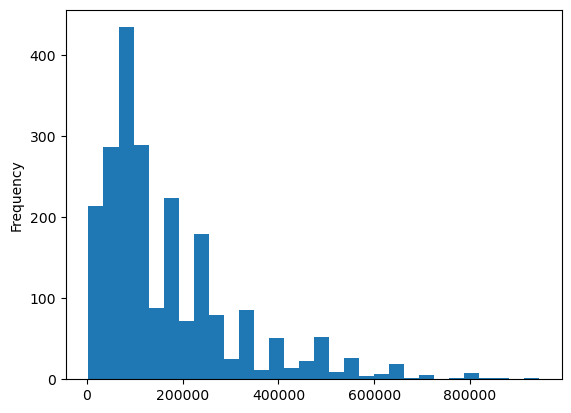

In [87]:

#data visualization
df.cost_num.plot(kind='hist', bins=30)
# plotting a histogram 

<AxesSubplot:ylabel='Frequency'>

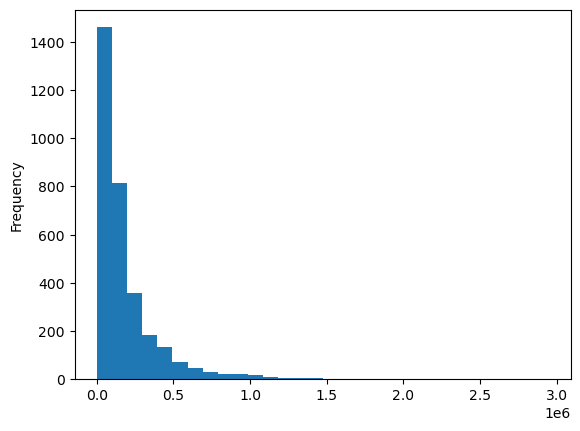

In [88]:
df.price_num.plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

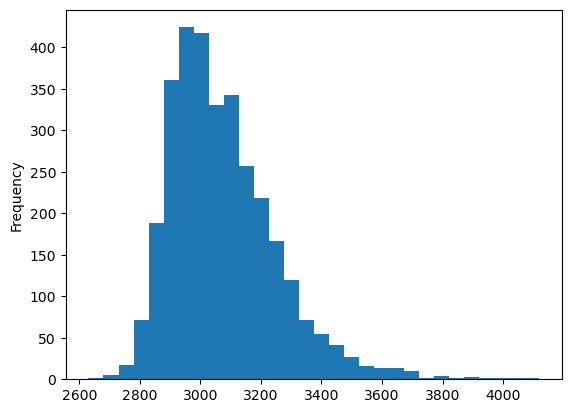

In [89]:
df.weight_num.plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

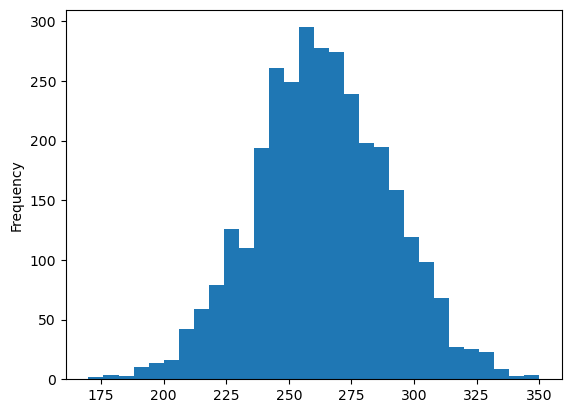

In [90]:
df.height_num.plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

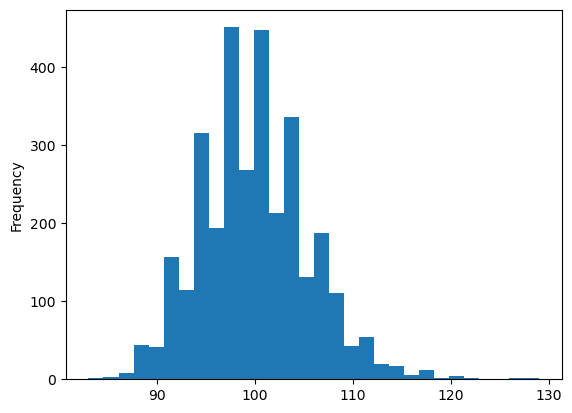

In [91]:
df.width_num.plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

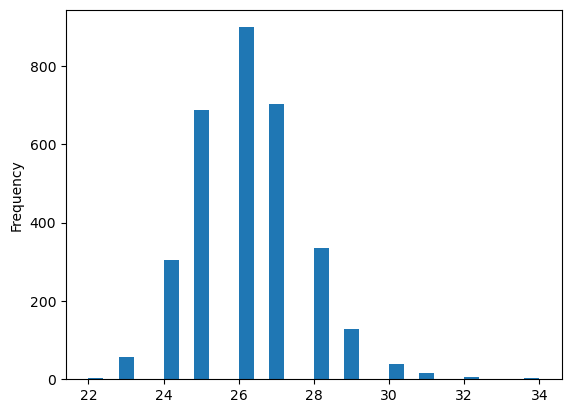

In [92]:
df.depth_num.plot(kind='hist', bins=30)

For categorical values, get value counts.(product_type,product_level,maker, and ingredient)

Note: We are not considering purchase_date now since we will use it to split my data into training and test data.

In [93]:
df.product_type.unique()

array(['Q,B', 'J,D', 'U', 'D,R', 'H', 'S', 'B,A', 'K,D', 'N', 'U,A', 'D',
       'H,A', 'G', 'D,A', 'T,H', 'D,H', 'F', 'A', 'Q,A', 'W', 'F,D', 'R',
       'P,H', 'C', 'Q,H', 'U,H', 'J', 'N,D', 'F,H', 'Q,D', 'V,H', 'W,D',
       'S,N', 'N,U', 'F,U', 'P,P', 'S,A', 'U,R', 'J,B', 'I,M', 'B,D',
       'H,M', 'S,U', 'K,H', 'S,B', 'T,D', 'F,A', 'K', 'V', 'N,A', 'B',
       'R,V', 'E', 'U,D', 'L,A', 'L', 'K,A', 'S,D', 'Q,N', 'T,A', 'O',
       'B,R', 'N,L', 'K,S'], dtype=object)

In [94]:
df.product_type.value_counts().head(20)

D      485
H      225
N      203
C      201
U      179
D,R    166
A      135
J,D     96
D,H     94
D,A     81
J,B     67
B,A     66
R       62
U,H     59
U,A     55
T,H     54
K       50
S,A     48
F,H     46
P,H     44
Name: product_type, dtype: int64

In [95]:
# Count the occurrences of each product type
product_counts = df['product_type'].value_counts()

# Define the number of product types to keep explicitly (e.g., keep top 20, wrap up the rest)
num_to_keep = 20

# Identify the product types to wrap up
types_to_wrap = product_counts.index[num_to_keep:]

# Replace the product types to be wrapped up with 'Others'
df.loc[df['product_type'].isin(types_to_wrap), 'product_type'] = 'Others'

# Count the wrapped up product types
wrapped_counts = df['product_type'].value_counts()

wrapped_counts.head(21)

Others    770
D         485
H         225
N         203
C         201
U         179
D,R       166
A         135
J,D        96
D,H        94
D,A        81
J,B        67
B,A        66
R          62
U,H        59
U,A        55
T,H        54
K          50
S,A        48
F,H        46
P,H        44
Name: product_type, dtype: int64

<AxesSubplot:ylabel='product_type'>

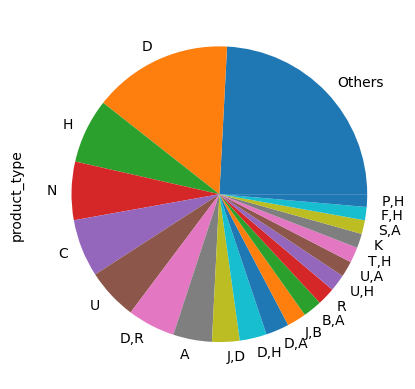

In [96]:
df.product_type.value_counts().plot(kind='pie')

<AxesSubplot:>

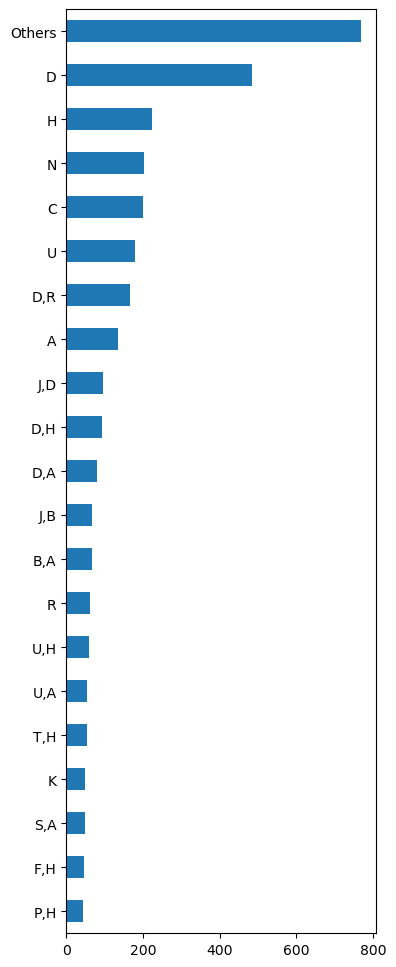

In [97]:
df.product_type.value_counts(ascending=True).plot(kind='barh', figsize=(4,12))

In [98]:
df.product_level.unique()

array(['advanced', 'basic', 'super advanced', 'intermediate', 'unrated'],
      dtype=object)

In [99]:
df.product_level.value_counts()

advanced          1320
super advanced    1222
intermediate       532
basic              111
unrated              1
Name: product_level, dtype: int64

<AxesSubplot:>

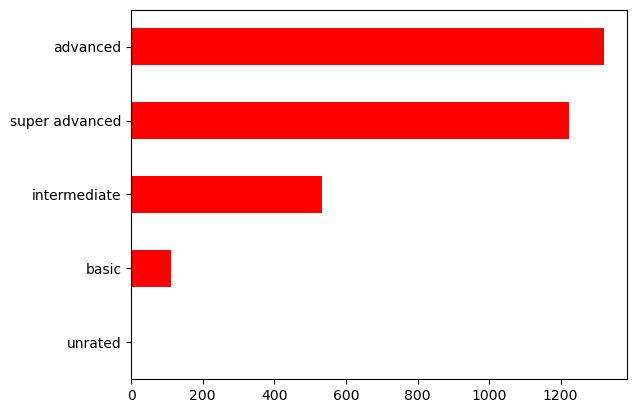

In [100]:
df.product_level.value_counts(ascending = True).plot(kind = 'barh',color = 'red')

In [101]:
df.maker.unique()

array(['M14122', nan, 'M14123', 'M14124', 'M14125', 'M14126', 'M14127',
       'M14128', 'M14129', 'M14130', 'M14131', 'M14132', 'M14133',
       'M14134,M14135', 'M14136', 'M14137', 'M14138,M14139', 'M14140',
       'M14141', 'M14142', 'M14143', 'M14144', 'M14145', 'M14146',
       'M14147', 'M14148', 'M14149', 'M14150', 'M14151', 'M14152',
       'M14153', 'M14154', 'M14155', 'M14156', 'M14157', 'M14158',
       'M14159', 'M14160', 'M14161', 'M14162', 'M14163', 'M14164',
       'M14165', 'M14166', 'M14167', 'M14168', 'M14169', 'M14170',
       'M14171', 'M14172', 'M14173', 'M14174', 'M14175', 'M14176',
       'M14177', 'M14178', 'M14179', 'M14180', 'M14181', 'M14182',
       'M14183', 'M14184', 'M14185', 'M14186', 'M14187', 'M14188',
       'M14189', 'M14190', 'M14191', 'M14192', 'M14193,M14194', 'M14195',
       'M14196', 'M14197', 'M14198,M14199', 'M14200', 'M14201', 'M14202',
       'M14194', 'M14203', 'M14204', 'M14205', 'M14206', 'M14207',
       'M14208', 'M14209', 'M14210', 'M

In [102]:
df.maker.value_counts().head()

M14196    17
M14346    16
M14170    15
M14163    15
M14164    13
Name: maker, dtype: int64

In [103]:
df.ingredient.unique()

array(['IN732052,IN732053',
       'IN732054,IN732055,IN732056,IN732057,IN732058',
       'IN732054,IN732059,IN732060', ...,
       'IN732490,IN732338,IN732503,IN732435,IN732583',
       'IN732832,IN732166,IN733162,IN733785,IN732069,IN732797',
       'IN733462,IN732654,IN732149,IN733067,IN734088,IN733474,IN732868,IN732266,IN732193'],
      dtype=object)

In [104]:
df.ingredient.value_counts()

IN732638                                                                            8
IN732362                                                                            6
IN732200                                                                            4
IN732859                                                                            4
IN732832                                                                            4
                                                                                   ..
IN733467,IN732523,IN733468                                                          1
IN732393,IN732893,IN732282                                                          1
IN732776,IN732531                                                                   1
IN732613,IN733132                                                                   1
IN733462,IN732654,IN732149,IN733067,IN734088,IN733474,IN732868,IN732266,IN732193    1
Name: ingredient, Length: 2824, dtype: int64

There are too many unique values for both maker and ingredient.

Check missing values for each feature.

In [105]:
df.isnull().sum()

cost             975
price              0
weight             3
purchase_date      0
product_type       0
product_level      0
maker            821
ingredient       254
height             0
width              3
depth              3
cost_num         975
price_num          0
weight_num         3
height_num         3
width_num          3
depth_num          3
dtype: int64

In [106]:
#There are many missing values in cost, and the distribution of cost is skewness, so we use median to fill up the missing values
median_cost = np.nanmedian(df['cost_num'])
df['cost_num'].fillna(median_cost, inplace=True)
df['cost_num'].isnull().sum()

0

In [107]:
#Only three missing values,just dropped them.
df.dropna(subset=['weight_num'],inplace=True)
df['weight_num'].isnull().sum()

0

In [108]:
df.isnull().sum()

cost             973
price              0
weight             0
purchase_date      0
product_type       0
product_level      0
maker            819
ingredient       253
height             0
width              0
depth              0
cost_num           0
price_num          0
weight_num         0
height_num         0
width_num          0
depth_num          0
dtype: int64

# 2. Feature Engineering

In [109]:
class Transformer():

    def fit(self, X, y=None):

        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['maker']= X['maker']
        df['product_level']= X['product_level'] 
        df['product_type']=X['product_type'].map(self.remove_comma)
        df['maker']= X['maker']
        df['ingredient']= X['ingredient'].map(self.remove_comma)
        
        self.mean = df.loc[:, ['cost', 'weight', 'height', 'width', 'depth']].mean()

    def transform(self, X, y=None):
 
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['maker']= X['maker']
        df['product_level']= X['product_level'] 
        df['product_type']=X['product_type'].map(self.remove_comma)
        df['maker']= X['maker']
        df['ingredient']= X['ingredient'].map(self.remove_comma)
        return df.fillna(self.mean)
 
    def fit_transform(self, X, y=None):
        '''
        Combine fit and transform
        Input: X dataframe
        '''        
        self.fit(X)
        return self.transform(X)
        
    # Convert cost string to numeric (unit: $)        
    def cost2num(self, x):
        if type(x) == str:
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

    # Convert weight string to numeric (unit: kg)
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip('Kg').strip().split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
    
    # Convert height string to numeric (unit: cm)
    def height2num(self, x):
        if type(x) == str:
            x = x.strip('meters').strip()
            return float(x)*100
        else:
            return x        
    
    # Convert width string to numeric (unit: cm)
    def width2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

    # Convert depth string to numeric (unit: cm)
    def depth2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   
        
    def price2num(self, x):
        if type(x) == str: # only works when x is a string
            x = x.strip('$') # remove the dollar sign at the front of the substring
            x = x.replace(',', '') # replace ','
            return float(x)
        else:
            return x
        
    def remove_comma(self, x):
        if type(x) == str: # only works when x is a string
            x = x.replace(',', ' ') # replace ','
            return x
        else:
            return ''

In [110]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [111]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [112]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [113]:
#Filling with mode for categorical values.

imp_mode = SimpleImputer(strategy='most_frequent')
df.loc[:, 'maker'] = imp_mode.fit_transform(df[['maker']])

imp_mode = SimpleImputer(strategy='most_frequent')
df.loc[:, 'ingredient'] = imp_mode.fit_transform(df[['ingredient']])

In [114]:
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [115]:
#Use VIF to check numerical colinearity
def compute_vif(df,considered_features):
    
    X = df[considered_features]
    X['intercept'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['cost_num','weight_num','height_num','width_num', 'depth_num']


compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
3,width_num,85.825449
2,height_num,62.742062
4,depth_num,24.563108
1,weight_num,20.245504
0,cost_num,1.110699


In [116]:
#!pip install phik
#Check phi correlation

In [117]:
X_train.head()

,cost,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth,cost_num,price_num,weight_num,height_num,width_num,depth_num,year
0,$333k,3 Ton 90 Kg,Dec 19 2008,Others,advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm,333000.0,300492.0,3090.0,276.0,97.0,26.0,2008
1,NaN,3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm,122000.0,430570.0,3030.0,267.0,98.0,26.0,1997
2,$270k,3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm,270000.0,213070.0,3040.0,300.0,93.0,24.0,2001
3,$97k,2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm,97000.0,122659.0,2970.0,247.0,101.0,26.0,2000
4,$59k,2 Ton 930 Kg,Aug 19 2011,H,super advanced,M14124,"IN732067,IN732068,IN732069,IN732070,IN732071,I...",2.71 meters,96 cm,25 cm,59000.0,60320.0,2930.0,271.0,96.0,25.0,2011


In [118]:
data_types = {'price':'interval',
              'cost':'interval',
              'weight':'interval',
              'height':'interval',
              'width':'interval',
              'depth':	'interval',
             'product_level':'ordinal',       
             'ingredient':'categorical',
             'maker':'categorical',
             'product_type':'categorical'}

In [119]:
X_train.phik_matrix()

interval columns not set, guessing: ['cost_num', 'price_num', 'weight_num', 'height_num', 'width_num', 'depth_num', 'year']


,cost,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth,cost_num,price_num,weight_num,height_num,width_num,depth_num,year
cost,1.000000,0.868009,0.982302,0.485725,0.179088,0.000000,0.000000,0.749672,0.000000,0.000000,1.000000,0.826629,0.654606,0.377038,0.000000,0.000000,0.364823
weight,0.868009,1.000000,0.968683,0.555072,0.391562,0.000000,0.995813,0.603725,0.739587,0.624089,0.691193,0.765929,1.000000,0.308362,0.583719,0.609406,0.201698
purchase_date,0.982302,0.968683,1.000000,0.494924,0.000000,0.000000,0.855044,0.000000,0.000000,0.000000,0.865388,0.814421,0.746173,0.000000,0.000000,0.000000,1.000000
product_type,0.485725,0.555072,0.494924,1.000000,0.675985,0.875980,0.972859,0.000000,0.177272,0.135430,0.431270,0.359040,0.461393,0.082679,0.128191,0.138990,0.197687
product_level,0.179088,0.391562,0.000000,0.675985,1.000000,0.829799,0.000000,0.000000,0.000000,0.057186,0.227937,0.146689,0.416480,0.000000,0.060945,0.043503,0.162611
maker,0.000000,0.000000,0.000000,0.875980,0.829799,1.000000,0.999968,0.902127,0.570670,0.752259,0.000000,0.191120,0.469687,0.411033,0.605284,0.696449,0.000000
ingredient,0.000000,0.995813,0.855044,0.972859,0.000000,0.999968,1.000000,0.996950,0.974187,0.949845,0.987776,0.997294,0.938019,0.875605,0.845811,0.876543,0.566017
height,0.749672,0.603725,0.000000,0.000000,0.000000,0.902127,0.996950,1.000000,0.970509,0.956140,0.455687,0.000000,0.382913,1.000000,0.935266,0.941269,0.000000
width,0.000000,0.739587,0.000000,0.177272,0.000000,0.570670,0.974187,0.970509,1.000000,0.996944,0.206567,0.133929,0.425492,0.890337,1.000000,0.996245,0.000000
depth,0.000000,0.624089,0.000000,0.135430,0.057186,0.752259,0.949845,0.956140,0.996944,1.000000,0.130736,0.022868,0.306685,0.787435,0.951217,1.000000,0.000000


Consider drop height, width, depth.

In [120]:
#!pip install category_encoders

In [121]:
cat_product_lvl=[["unrated", "basic", "intermediate", "advanced", "super advanced"]]


cat_transformer = make_column_transformer(
    (category_encoders.CountEncoder(),['maker']),
    (OrdinalEncoder(categories=cat_product_lvl), ['product_level']),
    (OneHotEncoder(handle_unknown='ignore'), ['product_type']),
    (TfidfVectorizer(max_features=10),'ingredient'),                                         
    remainder='passthrough',
)

In [122]:
cat_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('countencoder',
                                 CountEncoder(combine_min_nan_groups=True),
                                 ['maker']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['unrated', 'basic',
                                                             'intermediate',
                                                             'advanced',
                                                             'super '
                                                             'advanced']]),
                                 ['product_level']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['product_type']),
                                ('tfidfvectorizer',
                                 TfidfVectorizer(max_features=10),
                                 'ingredient')])

# 3 Build Model

# Random Forest

In [123]:
class columnDropTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

def build_ml_pipeline(regressor):

    steps = [ 
         ('tf', Transformer()),
         ("columnDropper", columnDropTransformer(['height','width', 'depth'])),
          ('ctf',cat_transformer),
         ('model', regressor)]

    model=Pipeline(steps)
    return model

In [124]:
ctf = make_column_transformer(
    (category_encoders.CountEncoder(),['maker']),
    (OrdinalEncoder(categories=cat_product_lvl), ['product_level']),
    (OneHotEncoder(handle_unknown='ignore'), ['product_type']),
    (TfidfVectorizer(max_features=10),'ingredient'),                                         
    remainder='passthrough',
)

tf =  Transformer()
cd = columnDropTransformer(['height','width', 'depth'])
#ctf = cat_transformer

In [125]:
#help(ctf.fit_transform)

In [126]:
x_train_tf = tf.fit_transform(X_train)
x_train_cd = cd.transform(x_train_tf)
x_train_ctf = ctf.fit_transform(x_train_cd)

In [127]:
x_train_cd.head()

,cost,weight,maker,product_level,product_type,ingredient
0,333000.000000,3090.0,M14122,advanced,Others,IN732052 IN732053
1,166207.183758,3030.0,NaN,basic,J D,IN732054 IN732055 IN732056 IN732057 IN732058
2,270000.000000,3040.0,NaN,basic,J D,IN732054 IN732059 IN732060
3,97000.000000,2970.0,NaN,advanced,D R,IN732064 IN732065 IN732066
4,59000.000000,2930.0,M14124,super advanced,H,IN732067 IN732068 IN732069 IN732070 IN732071 I...


In [128]:
x_train_ctf[0,:]

<1x35 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [129]:
pipeline = build_ml_pipeline(RandomForestRegressor(random_state=0))
model = pipeline.fit(X_train, y_train)

In [130]:
y_train_pred = model.predict(X_train)
y_test_pred=model.predict(X_test)

In [131]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 3.79e+04
train MSE: 3.57e+09
train R2: 0.916


In [149]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.27e+05
test MSE: 5.51e+10
test R2: 0.362


model performance (MAE, MSE and R2) in train set much better than test set, indicating overfitting.

In [133]:
parameters = {
    'rf__max_depth': [3, 6, 9, 20, 50, 100], #default is None, which means infinity
    'rf__min_samples_leaf': [1, 3, 5, 10, 20],
    'rf__min_samples_split': [2, 3, 5, 8]
}

In [134]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [135]:
steps = [
    ('tf', Transformer()),
    ("columnDropper", columnDropTransformer(['height','width', 'depth'])),
    ('ctf',cat_transformer),
    ('rf', RandomForestRegressor(n_estimators=50,n_jobs=-1)),
]
model = Pipeline(steps)

In [136]:
model_gsv = GridSearchCV(model,
                         parameters,
                         cv = 3,
                         scoring = scorer,
                         n_jobs=-1,
                         return_train_score=True)

In [137]:
model_gsv = model_gsv.fit(X_train, y_train)

In [138]:
model_gsv.best_score_

-25662926534.1006

In [139]:
model_gsv.cv_results_

{'mean_fit_time': array([0.22090904, 0.23890146, 0.26241048, 0.26908223, 0.31191738,
        0.30625176, 0.27441009, 0.21356416, 0.24789866, 0.25204881,
        0.27218334, 0.32285293, 0.28151568, 0.24222358, 0.21406921,
        0.2727313 , 0.26980082, 0.2920483 , 0.31693848, 0.36028981,
        0.29324945, 0.29775405, 0.34131606, 0.38470793, 0.456225  ,
        0.519394  , 0.47704832, 0.31524793, 0.43503594, 0.37152267,
        0.37235483, 0.49641109, 0.336924  , 0.28995156, 0.32280366,
        0.3091197 , 0.33290029, 0.42374476, 0.40817881, 0.40935349,
        0.44566305, 0.55123313, 0.47528402, 0.56529005, 0.71448119,
        0.65431372, 0.53646564, 0.43347168, 0.49267125, 0.4927845 ,
        0.4934655 , 0.63614051, 0.57596143, 0.42941435, 0.36922932,
        0.40534091, 0.54296931, 0.5654761 , 0.51511765, 0.42460171,
        0.79716301, 0.99570489, 1.28823066, 1.31806461, 1.08819858,
        1.05085746, 0.70374648, 0.60975083, 0.59758147, 0.79059219,
        0.89828094, 0.82155522,

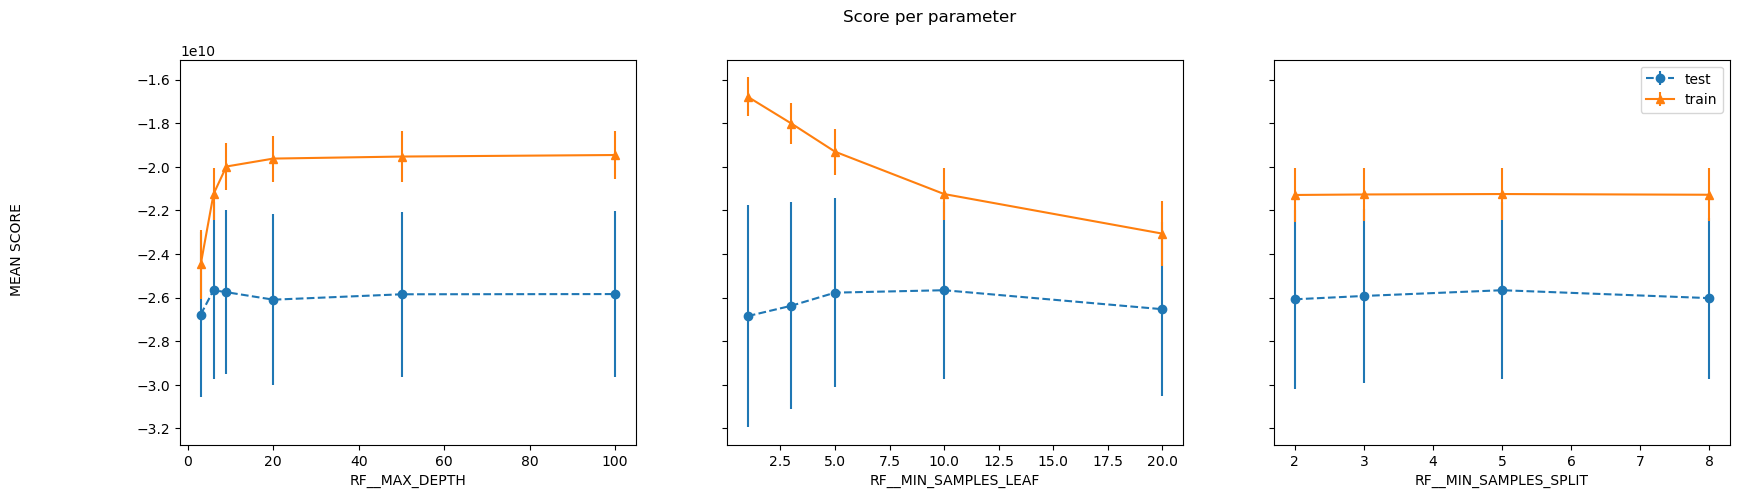

In [140]:

def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    params = grid.param_grid
    
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))              
    
    params=grid.param_grid   
    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    
    pram_preformace_in_best = {}                         

    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])           
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(model_gsv)

In [141]:
model_gsv.best_estimator_

Pipeline(steps=[('tf', <__main__.Transformer object at 0x000001756E052C40>),
                ('columnDropper',
                 <__main__.columnDropTransformer object at 0x000001756E052100>),
                ('ctf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('countencoder',
                                                  CountEncoder(combine_min_nan_groups=True),
                                                  ['maker']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['product_type']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=10),
                                                  'ingredient')])),
                ('rf',
                 RandomForestRegressor(max_depth=6, min_samples_leaf=10,
                                       min_samples_split=5, n_estimators=50,
                                       n_jobs=-1))])

In [142]:
y_train_pred = model_gsv.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 9.43e+04
train MSE: 2.16e+10
train R2: 0.494


In [143]:
y_test_pred = model_gsv.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.22e+05
test MSE: 5.05e+10
test R2: 0.416


# Xgboost

In [145]:
# Xgboost model 
pipeline = build_ml_pipeline(XGBRegressor())
model=pipeline.fit(X_train, y_train)

In [146]:
y_train_pred = model.predict(X_train)
y_test_pred=model.predict(X_test)

In [147]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 4.54e+04
train MSE: 4.25e+09
train R2: 0.900


In [148]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.27e+05
test MSE: 5.51e+10
test R2: 0.362


model performance (MAE, MSE and R2) in train set much better than test set, indicating overfitting.

In [150]:
parameters = {
    'xgb__max_depth': [3, 6, 9, 20, 50, 100], #default is None, which means infinity
    'xgb__min_samples_leaf': [1, 3, 5, 10, 20],
    'xgb__min_samples_split': [2, 3, 5, 8]
}

In [151]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [152]:
steps = [
    ('tf', Transformer()),
    ("columnDropper", columnDropTransformer(['height','width', 'depth'])),
    ('ctf',cat_transformer),
    ('xgb', XGBRegressor(n_estimators=50,n_jobs=-1)),
]
xgb_model = Pipeline(steps)

In [153]:
xgb_model_gsv = GridSearchCV(xgb_model,
                         parameters,
                         cv = 3,
                         scoring = scorer,
                         n_jobs=-1,
                         return_train_score=True)

In [154]:
xgb_model_gsv = xgb_model_gsv.fit(X_train, y_train)

[00:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



In [155]:
y_train_pred = xgb_model_gsv.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 8.43e+04
train MSE: 1.60e+10
train R2: 0.624


In [156]:
y_test_pred = model_gsv.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.22e+05
test MSE: 5.05e+10
test R2: 0.416
